In [1]:
from SL_C0de.grid import ICE_TIME_GRID
from SL_C0de.grid import SEDIMENT_TIME_GRID
from SL_C0de.grid import TOPOGRAPHIC_TIME_GRID
from SL_C0de.grid import OCEAN_TIME_GRID
from SL_C0de.love import LOVE
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)

maxdeg=512
stop=122 # define the number of time steps
step=1
time_step=np.arange(start=stop,stop=-step,step=-step)

Input_way='C:/Users/ahenry01/Desktop/Python_code/Interpolated_grid'
love_way='C:/Users/ahenry01/Desktop/Python_code/SL_C0de_data/'
love_file='VM5a_122'

ice_time_grid=ICE_TIME_GRID(from_file=(True,Input_way+'/ICE/ice_ICE6G_122_512'))
sed_time_grid=SEDIMENT_TIME_GRID(from_file=(True,Input_way+'/SED/sed_AYS1_122_512'))
topo_time_grid=TOPOGRAPHIC_TIME_GRID(from_file=(True,Input_way+'/TOPO/topo_topo_SL_122_512'))


In [ ]:
# Initiate the base elements
from SL_C0de.spharm import sphericalobject
from SL_C0de.Load import LOAD
load=LOAD(maxdeg,ice_time_grid.time_step)
topo_time_grid.update_0()
ocean_time_grid.evaluate_ocean(topo_time_grid.grd_0).grdtocoeff()
ocean_time_grid.update_0()
ocean_time_grid.save_prev()
ice_time_grid.sdeli_00=ice_time_grid.height_time_coeff[0,0] # peut être à passer dans l'initialisation ou le modify de ice object après leurs création
topo_time_grid.grid_from_step(0)
# grd correspond donc au topo_j défini dans le code de kendal et al.
ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
TO=sphericalobject(grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)).grdtocoeff()
TO.prev=np.zeros(TO.coeff.shape)


In [ ]:
for t_it in range (ice_time_grid.time_step_number):
    topo_time_grid.grid_from_step(t_it)
    # grd correspond donc au topo_j défini dans le code de kendal et al.
    ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
    TO.grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)
    TO.grdtocoeff()
    sed_time_grid.coeff_from_step(t_it)
    ice_time_grid.coeff_from_step(t_it)
    ice_time_grid.sdeli_00=ice_time_grid.coeff[0]
    


    conv_lim=10**(-3)
    print(ice_time_grid.time_step[t_it])
    if t_it==0 : 
        conv_it=0
    else :
        conv_it=1
    ocean_time_grid.sea_level_solver(load,ice_time_grid,sed_time_grid,love_number,TO,t_it,conv_it,conv_lim)


    
    #print(ocean_time_grid.delPhi_g)

    ocean_time_grid.prev=ocean_time_grid.height_time_coeff[t_it,:].copy()
    # if t_it==0:
    #     print(ocean_time_grid.height_time_coeff[t_it,:])
    TO.prev=TO.coeff.copy()
    if t_it==0:
        ice_time_grid.deli_00_prev=ice_time_grid.height_time_coeff[0,0]
    else :
        ice_time_grid.deli_00_prev=ice_time_grid.height_time_coeff[:t_it,0].sum(0)
    

    topo_time_grid.height_time_grid[t_it,:,:]=topo_time_grid.height_time_grid[t_it,:,:]-(ocean_time_grid.delSLcurl.grd+ocean_time_grid.delPhi_g)

From here you can do two things. simply solving the sea level equation. Wich would be on one iteration. The sea level equation is a differential equation with the ocean load on two side of the equation. Therefor, we need to converge the code toward the solution by updating the ocean load on both side of the equation. First we will solve the sea level equation at one step. 

In [ ]:
ocean_time_grid.timecoefftotimegrd()


In [ ]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=100

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(ocean_time_grid.height_time_grid[1:t_it,:,:].sum(0), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('ice_variaton (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [ ]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=100

cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=-200,vmax=200,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(topo_time_grid.height_time_grid[-1,:,:]-ice_time_grid.height_time_grid.sum(0)-sed_time_grid.height_time_grid.sum(0)-(topo_time_grid.height_time_grid[t_it,:,:]-ice_time_grid.height_time_grid[:t_it+1,:,:].sum(0)-sed_time_grid.height_time_grid[:t_it+1,:,:].sum(0)), origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('ice_variaton (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [2]:
# Initiate the base elements
from SL_C0de.spharm import sphericalobject
from SL_C0de.Load import LOAD
import math 


ocean_time_grid=OCEAN_TIME_GRID(time_step,maxdeg,grid_name='OCEAN_122_512')
ocean_time_grid.time_step_number=ocean_time_grid.time_step_number

ice_time_grid.timegrdtotimecoeff()
sed_time_grid.timegrdtotimecoeff()

love_number=LOVE(maxdeg,love_way+love_file,time_step,6371000,5.9742e24)
love_number.calc_beta
TO=sphericalobject(coeff=np.zeros(ice_time_grid.height_time_coeff[0,:].shape))

load=LOAD(maxdeg,ice_time_grid.time_step)

topo_diff_median=np.inf
#sdel_topo_diff=np.inf
topo_it=0
while topo_diff_median>10**(0) : #and sdel_topo_diff>10**(-1):
    delPhi_g_time=np.array([])
    TO.prev=np.zeros(ice_time_grid.height_time_coeff[0,:].shape)

    if topo_diff_median != np.inf :
        topo_time_grid.height_time_grid[0,:,:]=topo_initial.copy()
    # topo_time_grid.height_time_grid = topo_time_grid.height_time_grid - ice_time_grid.height_time_grid + ice_time_grid.ice # for resetting the corrected ice.
    ice_time_grid.ice_correction(topo_time_grid,ocean_time_grid)
    ice_time_grid.timegrdtotimecoeff()
    
    topo_time_grid.update_0()
    ocean_time_grid.evaluate_ocean(topo_time_grid.grd_0).grdtocoeff()
    ocean_time_grid.update_0()
    ocean_time_grid.save_prev()
    topo_time_grid.grid_from_step(0)
    # grd correspond donc au topo_j défini dans le code de kendal et al.
    ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
    TO.grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)
    TO.grdtocoeff()

    track_conv=np.array([])

    for t_it in range (1,ice_time_grid.time_step_number-1):
        topo_time_grid.grid_from_step(t_it)
        # grd correspond donc au topo_j défini dans le code de kendal et al.
        ocean_time_grid.evaluate_ocean(topo_time_grid.grd).grdtocoeff()
        TO.grd=topo_time_grid.grd_0*(ocean_time_grid.grd-ocean_time_grid.grd_0)
        TO.grdtocoeff()
        sed_time_grid.coeff_from_step(t_it)
        ice_time_grid.coeff_from_step(t_it)
        


        conv_lim=10**(-10)
        print('time_iteration : ',ice_time_grid.time_step[t_it])
        if topo_it==0 : 
            conv_it=0
        else :
            conv_it=1
        conv_it=ocean_time_grid.sea_level_solver(load,ice_time_grid,sed_time_grid,love_number,TO,t_it,conv_it,conv_lim)

        track_conv=np.append(track_conv,conv_it)     
        
        TO.prev=TO.coeff.copy()

        ocean_time_grid.save_prev()
        
        topo_time_grid.height_time_grid[t_it,:,:]=topo_time_grid.grd_0-(ocean_time_grid.delSLcurl.grd+ocean_time_grid.delPhi_g)

        #delPhi_g_time=np.append(delPhi_g_time,ocean_time_grid.delPhi_g)

    topo_it+=1
    topo_pres_ice_corrected=topo_time_grid.topo_pres-ice_time_grid.ice.sum(0)+ice_time_grid.height_time_grid.sum(0)
    topo_diff=np.abs(topo_time_grid.height_time_grid[-1,:,:]-topo_pres_ice_corrected).max().max()
    sdel_topo_diff=np.abs(topo_diff-np.abs(topo_time_grid.height_time_grid[-1,:,:]-topo_pres_ice_corrected).max().max())
    topo_diff_mean=np.abs(topo_time_grid.height_time_grid[-1,:,:]-topo_pres_ice_corrected).mean().mean()
    topo_diff_median=np.median(np.median(np.abs(topo_time_grid.height_time_grid[-1,:,:]-topo_pres_ice_corrected)))
    print(topo_it,' : ',topo_diff, topo_diff_mean, topo_diff_median, sdel_topo_diff,track_conv-(topo_it>0))
    topo_initial=topo_pres_ice_corrected - (topo_time_grid.height_time_grid[-1,:,:]-topo_time_grid.height_time_grid[0,:,:])

time_iteration :  121.0
time_iteration :  120.0
time_iteration :  119.0
time_iteration :  118.0
time_iteration :  117.0
time_iteration :  116.0
time_iteration :  115.0
time_iteration :  114.0
time_iteration :  113.0
time_iteration :  112.0
time_iteration :  111.0
time_iteration :  110.0
time_iteration :  109.0
time_iteration :  108.0
time_iteration :  107.0
time_iteration :  106.0
time_iteration :  105.0
time_iteration :  104.0
time_iteration :  103.0
time_iteration :  102.0
time_iteration :  101.0
time_iteration :  100.0
time_iteration :  99.0
time_iteration :  98.0
time_iteration :  97.0
time_iteration :  96.0
time_iteration :  95.0
time_iteration :  94.0
time_iteration :  93.0
time_iteration :  92.0
time_iteration :  91.0
time_iteration :  90.0
time_iteration :  89.0
time_iteration :  88.0
time_iteration :  87.0
time_iteration :  86.0
time_iteration :  85.0
time_iteration :  84.0
time_iteration :  83.0
time_iteration :  82.0
time_iteration :  81.0
time_iteration :  80.0
time_iterati

In [3]:
#Saving the code :
ocean_time_grid.timecoefftotimegrd()
import os 
Love_numbers='/VM5a_122'
Output_way='C:/Users/ahenry01/Desktop/Python_code/Output_grid'
if not(os.path.exists(Output_way+Love_numbers)):
    os.mkdir(Output_way+Love_numbers)
#ocean_time_grid.save(Output_way+Love_numbers)
#ice_time_grid.time_grid_name="ice_ICE6G_122_512"
ice_time_grid.save(Output_way+Love_numbers)
#topo_time_grid.time_grid_name="topo_topo_SL_122_512"
topo_time_grid.save(Output_way+Love_numbers)

In [3]:
#ocean_time_grid.time_step_number-=1
ocean_time_grid.timecoefftotimegrd()

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_12032\3541490392.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


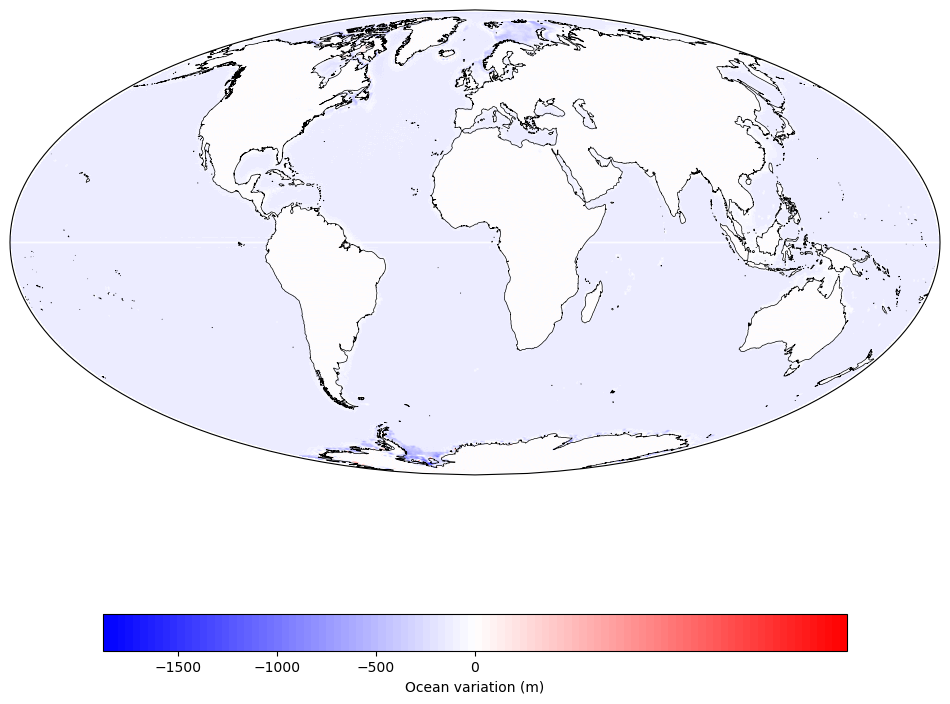

In [6]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=np.where(ocean_time_grid.time_step==26)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[t_it-1:,:].sum(0)
grid,lon_hd,lat_hd=ocean_time_grid.coefftogrdhd(1024)
grid=-grid
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(grid, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('Ocean variation (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_11136\717898543.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)


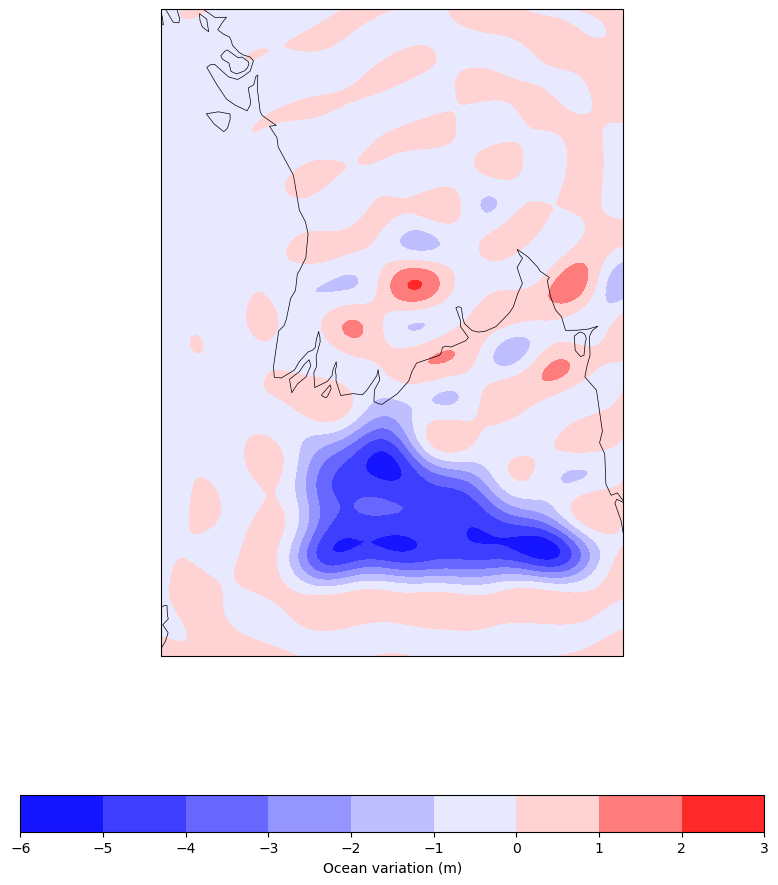

In [30]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

from SL_C0de.grid import OCEAN_TIME_GRID
from SL_C0de.grid import SEDIMENT_TIME_GRID
from SL_C0de.grid import ICE_TIME_GRID

Input_way='C:/Users/ahenry01/Desktop/Python_code/Output_grid/VM5a_122'

ocean_time_grid=OCEAN_TIME_GRID(from_file=(True,Input_way+'/OCEAN_122_512'))
ice_time_grid=ICE_TIME_GRID(from_file=(True,Input_way+'/ice_ICE6G_122_512'))

Input_way='C:/Users/ahenry01/Desktop/Python_code/Interpolated_grid'
sed_time_grid=SEDIMENT_TIME_GRID(from_file=(True,Input_way+'/SED/sed_AYS1_122_512'))


t_it=np.where(ocean_time_grid.time_step==0)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
sed_time_grid.grd=sed_time_grid.height_time_grid[t_it-1:,:,:].sum(0)
ice_time_grid.grd=ice_time_grid.height_time_grid[t_it-1:,:,:].sum(0)
ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[t_it-1:,:].sum(0)+sed_time_grid.grdtocoeff().coeff+ice_time_grid.grdtocoeff().coeff
grid,lon_hd,lat_hd=ocean_time_grid.coefftogrdhd(4000)
grid=-grid
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")
area=(93,98,13,20)

lat_hd=lat_hd[::-1]
#find the closest position :
lon_lim_min=np.abs(lon_hd-area[0]).argmin()
lon_lim_max=np.abs(lon_hd-area[1]).argmin()
lat_lim_min=np.abs(lat_hd-area[2]).argmin()
lat_lim_max=np.abs(lat_hd-area[3]).argmin()
lon=lon_hd[lon_lim_min:lon_lim_max+1]
lat=lat_hd[lat_lim_min:lat_lim_max+1]
grid=grid[lat_lim_min:lat_lim_max+1,lon_lim_min:lon_lim_max+1]

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.set_extent(area)
m2 = ax1.contourf(lon,lat,grid, origin='lower', transform=ccrs.PlateCarree(),extent=area, zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('Ocean variation (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_18120\3059754017.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)
c:\Users\ahenry01\miniconda3\envs\SL_C0de\Lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'interpolation'
  result = super().contourf(*args, **kwargs)


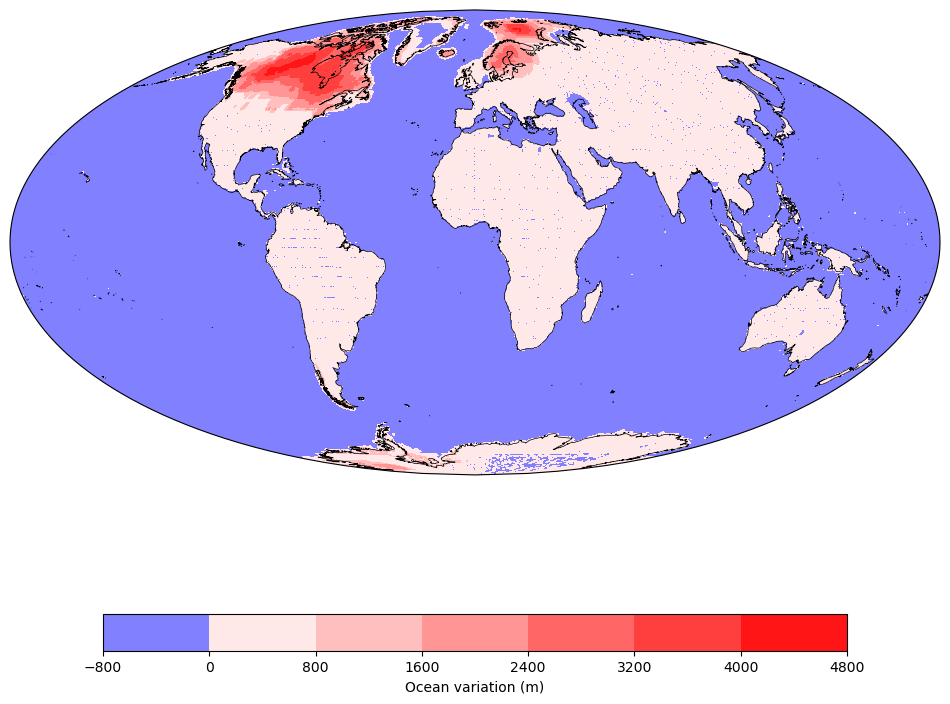

In [2]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

from SL_C0de.grid import OCEAN_TIME_GRID
from SL_C0de.grid import SEDIMENT_TIME_GRID
from SL_C0de.grid import ICE_TIME_GRID

Input_way='C:/Users/ahenry01/Desktop/Python_code/Output_grid/VM5a_122'

ocean_time_grid=OCEAN_TIME_GRID(from_file=(True,Input_way+'/OCEAN_122_512'))
ice_time_grid=ICE_TIME_GRID(from_file=(True,Input_way+'/ice_ICE6G_122_512'))

Input_way='C:/Users/ahenry01/Desktop/Python_code/Interpolated_grid'
sed_time_grid=SEDIMENT_TIME_GRID(from_file=(True,Input_way+'/SED/sed_AYS1_122_512'))


t_it=np.where(ocean_time_grid.time_step==26)[0][0]
#ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[:t_it,:].sum(0)-ocean_time_grid.height_time_coeff.sum(0)
sed_time_grid.grd=sed_time_grid.height_time_grid[t_it-1:,:,:].sum(0)
ice_time_grid.grd=ice_time_grid.height_time_grid[t_it-1:,:,:].sum(0)
ocean_time_grid.coeff=ocean_time_grid.height_time_coeff[t_it-1:,:].sum(0)+sed_time_grid.grdtocoeff().coeff+ice_time_grid.grdtocoeff().coeff
grid,lon_hd,lat_hd=ocean_time_grid.coefftogrdhd(512)
grid=-grid
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")


norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.contourf(lon_hd,lat_hd,grid, origin='lower', transform=ccrs.PlateCarree(), zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('Ocean variation (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

In [55]:
fig.savefig('test.pdf')

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_12032\2939963280.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)
c:\Users\ahenry01\miniconda3\envs\SL_C0de\Lib\site-packages\cartopy\mpl\geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


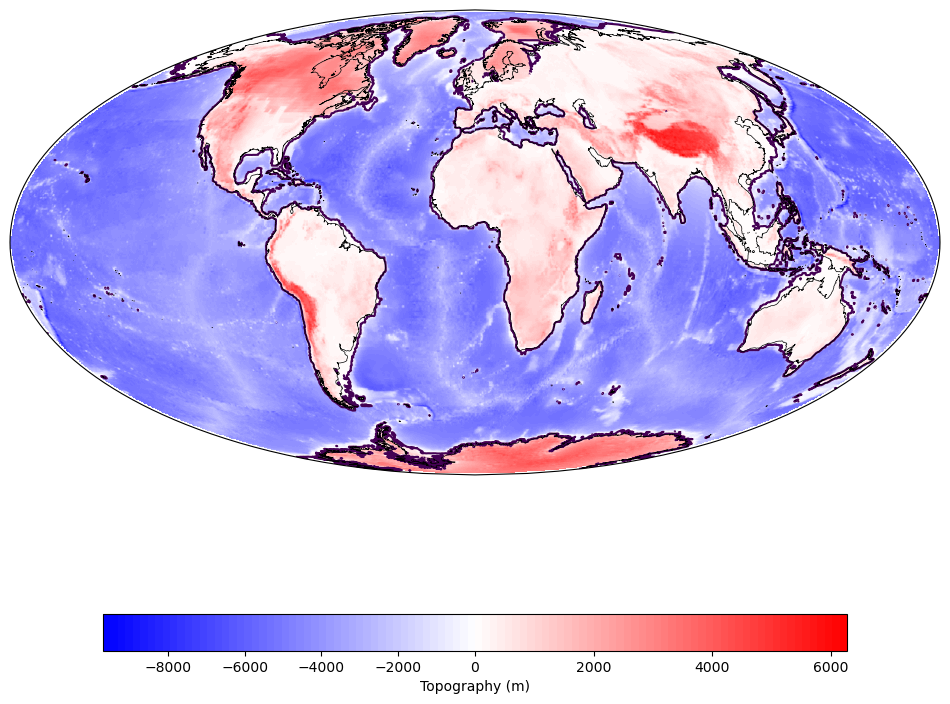

In [12]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=np.where(topo_time_grid.time_step==26)[0][0]
grid=topo_time_grid.height_time_grid[t_it,:,:]#topo_time_grid.height_time_grid[t_it,:,:]
#grid=topo_initial
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(grid, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
ax1.contour(topo_time_grid.elons,-topo_time_grid.lats,grid,[0], transform=ccrs.PlateCarree(),linewidth=coast_line_width)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('Topography (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)

C:\Users\ahenry01\AppData\Local\Temp\ipykernel_6824\2909653828.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('bwr', 100)
c:\Users\ahenry01\miniconda3\envs\SL_C0de\Lib\site-packages\cartopy\mpl\geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


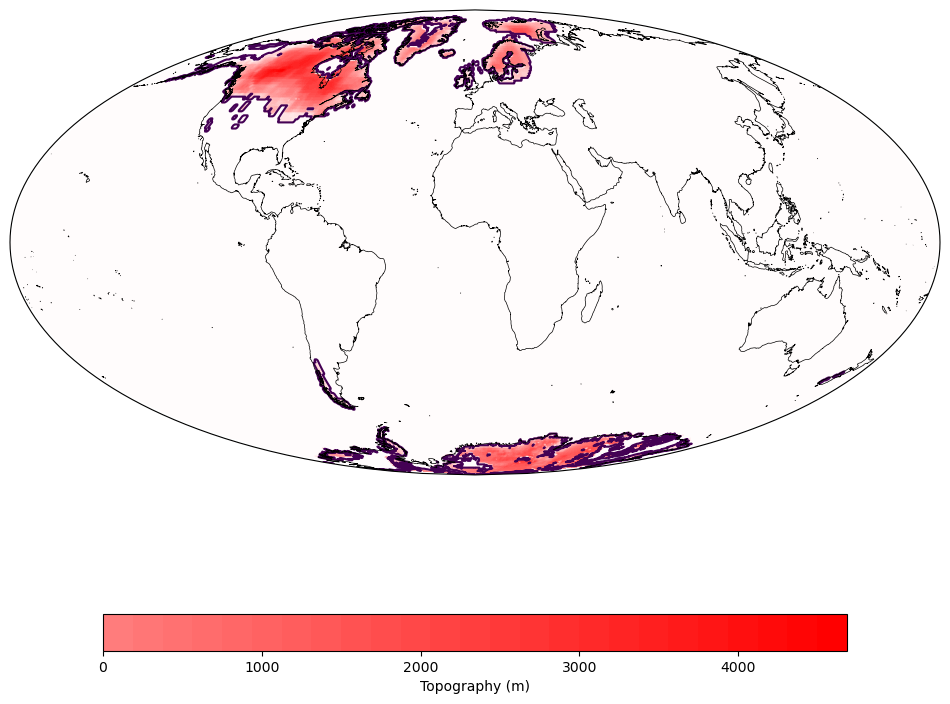

In [8]:
import cartopy
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

t_it=np.where(ocean_time_grid.time_step==25)[0][0]
grid=ice_time_grid.height_time_grid[:t_it+1,:,:].sum(0)
#grid=topo_initial
cmap=cm.get_cmap('bwr', 100)
alpha_ocean=0
coast_line_width=0.5

fig = plt.figure(figsize=(12, 12), facecolor="none")

norm = colors.TwoSlopeNorm(vmin=None,vmax=None,vcenter=0)
#norm = colors.TwoSlopeNorm(vmin=ocean_time_grid.height_time_grid[t_it,:,:].min(),vmax=ocean_time_grid.height_time_grid[t_it,:,:].max(),vcenter=0)
ax1  = plt.subplot(111, projection=ccrs.Mollweide())
ax1.set_global()
m2 = ax1.imshow(grid, origin='lower', transform=ccrs.PlateCarree(),extent=[0,360, -89, 89], zorder=0, cmap=cmap, interpolation="gaussian",norm=norm)
ax1.contour(topo_time_grid.elons,-topo_time_grid.lats,grid,[0], transform=ccrs.PlateCarree(),linewidth=coast_line_width)
cbar2=plt.colorbar(mappable=m2, orientation="horizontal", shrink=0.8)
cbar2.set_label('Topography (m)')
#cbar2.set_ticks([ocean_time_grid.height_time_grid[t_it,:,:].min(), 0, ocean_time_grid.height_time_grid[t_it,:,:].max()])
ax1.add_feature(cartopy.feature.OCEAN, alpha=alpha_ocean, zorder=99, facecolor="#BBBBBB")
ax1.coastlines(resolution="50m", zorder=100, linewidth=coast_line_width)